<a href="https://colab.research.google.com/github/keerthinc/2w_app/blob/main/LayoutLMv2Processor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up environment

We install HuggingFace Transformers and Detectron2.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install -q pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install -q torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
!pip install -q datasets

We also install PyTesseract:

In [4]:
! sudo apt install tesseract-ocr
! pip install -q pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [6]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


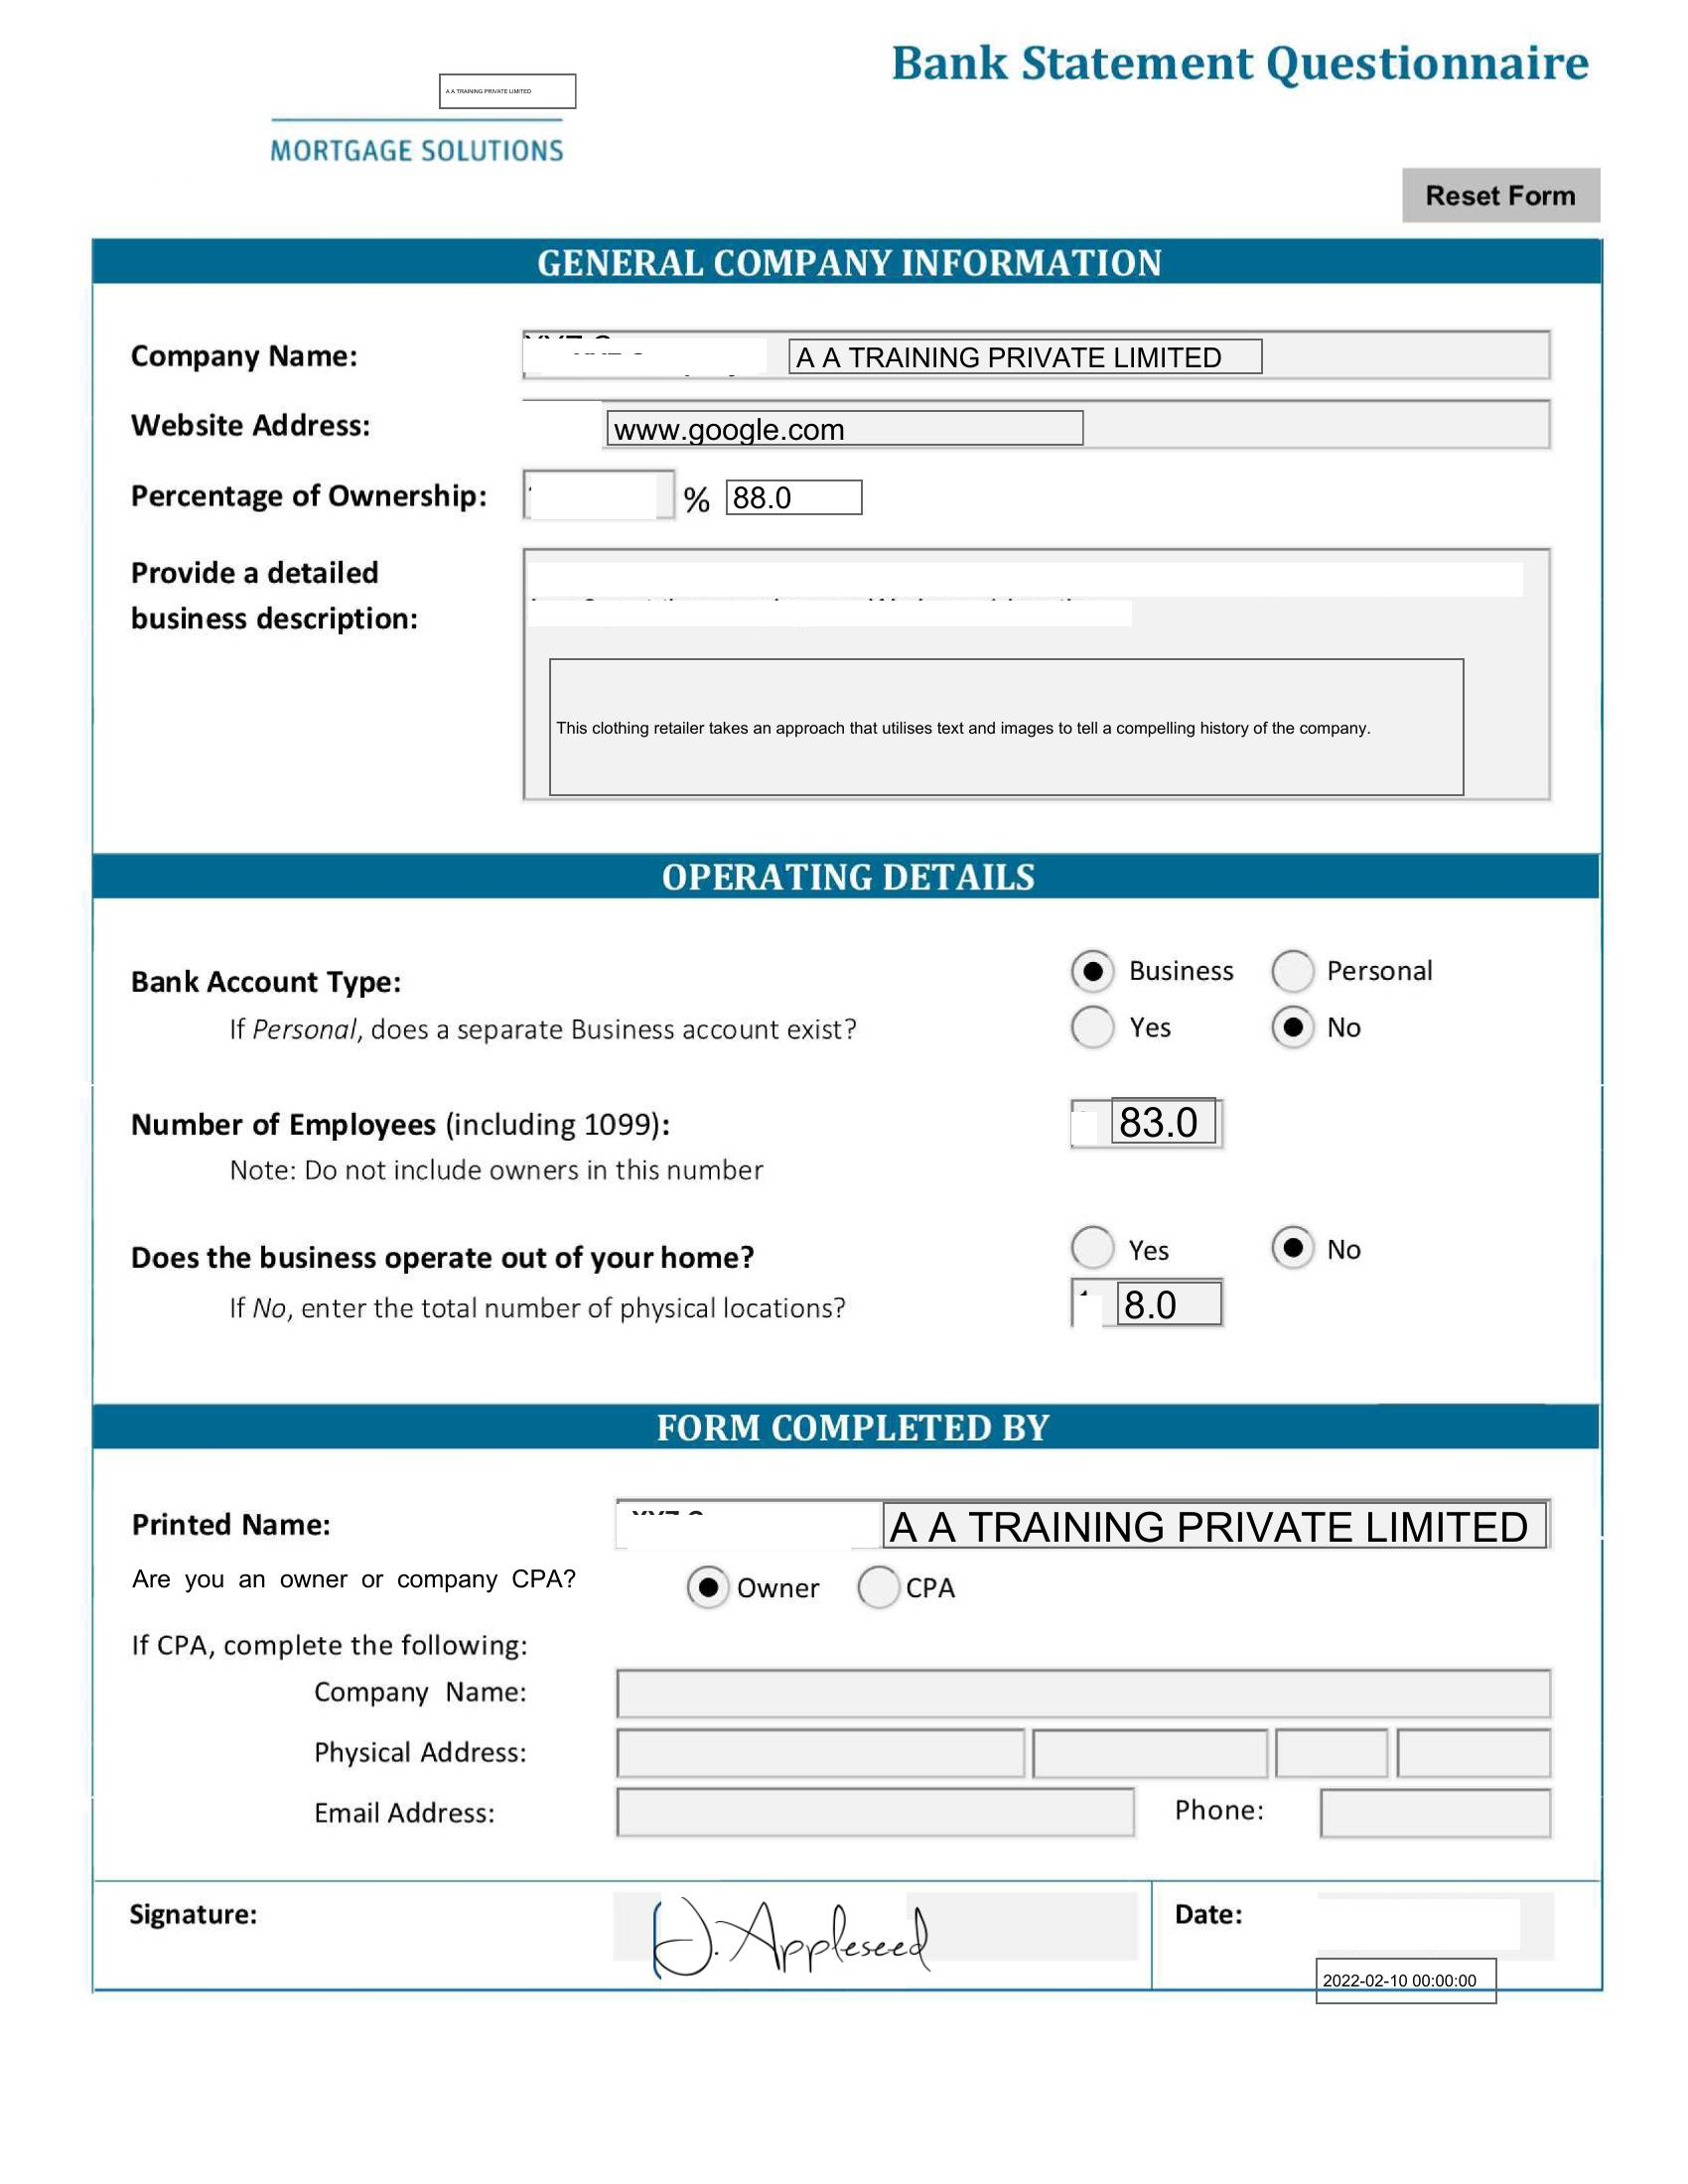

In [29]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("sample_data/bank/0out.pdf.jpg")
image = image.convert("RGB")
image

We can use the Tesseract OCR engine to turn the image into a list of recognized words:

In [31]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'Bank Statement Questionnaire MORTGAGE SOLUTIONS GENERAL COMPANY INFORMATION Company Name: [ “-—- [AA TRAINING PRIVATE LIMITED Website Address: www.google.com Percentage of Ownership: | % |88.0 Provide a detailed business description: This clothing retailer takes an approach that utilises text and images to tell a compelling history of the company. OPERATING DETAILS Bank Account Type: (@) Business i) Personal If Personal, does a separate Business account exist? © Yes (e No Number of Employees (including 1099): | Note: Do not include owners in this number Does the business operate out of your home? © Yes (@) No If No, enter the total number of physical locations? * |8.0 Printed Name: a A A TRAINING PRIVATE LIMITED | Are you an owner or company CPA? (@) Owner & CPA If CPA, complete the following: Company Name: Physical Address: Email Address: Phone: Signature: A 0 ) Date: bi ECSEL OS) re'

However, we can use `LayoutLMv2Processor` to easily prepare the data for the model. We give a document image as input to the processor, and it will create `input_ids`, `attention_mask`, `token_type_ids` and `bbox` for us. Internally, it will apply PyTesseract to get the words and bounding boxes, it will normalize the bounding boxes according to the size of the image, and it will turn everything into token-level inputs. It will also resize the document image to 224x224, as the model also requires an `image` input. Handy, isn't it?

Btw, if you prefer to use your own OCR engine, you still can. In that case, you can provide your own words and (normalized) bounding boxes to the processor.

In [74]:
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor = LayoutLMv2Processor(feature_extractor, tokenizer)

In [75]:
encoded_inputs = processor(image, return_tensors="pt")

In [76]:
for k,v in encoded_inputs.items():
  print(k, v.shape)

input_ids torch.Size([1, 206])
bbox torch.Size([1, 206, 4])
token_type_ids torch.Size([1, 206])
attention_mask torch.Size([1, 206])
image torch.Size([1, 3, 224, 224])


Let's check whether the `input_ids` are created correctly by decoding them back to text:

In [77]:
processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())

'[CLS] bank statement questionnaire mortgage solutions general company information company name : [ “ - — - [ aa training private limited website address : www. google. com percentage of ownership : | % | 88. 0 provide a detailed business description : this clothing retailer takes an approach that utilises text and images to tell a compelling history of the company. operating details bank account type : ( @ ) business i ) personal if personal, does a separate business account exist? © yes ( e no number of employees ( including 1099 ) : | note : do not include owners in this number does the business operate out of your home? © yes ( @ ) no if no, enter the total number of physical locations? * | 8. 0 printed name : a a a training private limited | are you an owner or company cpa? ( @ ) owner & cpa if cpa, complete the following : company name : physical address : email address : phone : signature : a 0 ) date : bi ecsel os ) re [SEP]'

Note that it also adds the special tokens ([CLS] and [SEP]). You can also pad to a max length, truncate, etc., just like you would do with a regular tokenizer.

## Preprocessing the data using datasets

First, we convert the dataset into a Pandas dataframe, having 2 columns: image_path and label.

*   List item

*   List item
*   List item


*   List item



In [78]:
import pandas as pd
import os

dataset_path = "sample_data"
labels = [label for label in os.listdir(dataset_path)]
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
label2id

{'.ipynb_checkpoints': 2, 'bank': 1, 'disaster': 0}

In [89]:
images = []
labels = []

for label_folder, _, file_names in os.walk(dataset_path):
  if label_folder != dataset_path:
    label = label_folder[40:]
    for _, _, image_names in os.walk(label_folder):
      relative_image_names = []
      for image_file in image_names:
        relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
      images.extend(relative_image_names)
      labels.extend([label] * len (relative_image_names)) 

data = pd.DataFrame.from_dict({'image_path': images, 'label': labels})
data.head()

,image_path,label
0,sample_data//d10out.pdf.jpg,
1,sample_data//d28out.pdf.jpg,
2,sample_data//d41out.pdf.jpg,
3,sample_data//d47out.pdf.jpg,
4,sample_data//d46out.pdf.jpg,


In [85]:
from datasets import Dataset 

# read dataframe as HuggingFace Datasets object
dataset = Dataset.from_pandas(data)

In [86]:
dataset

Dataset({
    features: ['image_path', 'label'],
    num_rows: 162
})

In [90]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(labels), names=labels),
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  
  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]

  return encoded_inputs

encoded_dataset = dataset.map(preprocess_data, remove_columns=dataset.column_names, features=features, 
                              batched=True, batch_size=2)

ValueError: ignored

Next, we set the format to PyTorch tensors. We also specify to put everything on the GPU (CUDA).

In [45]:
encoded_dataset.set_format(type="torch", device="cuda")

We can create a PyTorch dataloader now:

In [46]:
import torch

dataloader = torch.utils.data.DataLoader(encoded_dataset, batch_size=4)
batch = next(iter(dataloader))

In [47]:
for k,v in batch.items():
  print(k, v.shape)

image torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 512])
attention_mask torch.Size([4, 512])
token_type_ids torch.Size([4, 512])
bbox torch.Size([4, 512, 4])
labels torch.Size([4])


In [48]:
processor.tokenizer.decode(batch['input_ids'][0].tolist())

'[CLS] tae appendix b. translation of editorial in algexeen dagslad ist septd snokers _ on the advance foundation smoking and health : : ‘ the hague - during this year the maber of smoke hes increased by 3¢ in comparison to lest year. the increase is the greatest ancngst men between 35 and 49 years ol ( zrom 44 % to 50 % ). amongst women en increase of 3t can be recorded in the large group of wonen between 20 and 50 years old. investigaticn « the above is apparent from 2 nipo - investigetion which is made annuzliy for the * foundaticn smoking end health. the foundation is of the opinion thet the new, so - called “ healthy " cigarette barclay is the great evil - doer. people think thet now their health is no longer in danger but an investigotion in the u. s. a. hes ‘ proved thet smokers, who slightly tompress the bercley filter between their lips, will inhale six tines more nicotine and tar than es steted on the package. st : s : 4 yy so - called persons vegretting ( wheppy ) choice ; a

In [49]:
id2label[batch['labels'][0].item()]

'disaster'

## Define the model

Here we define the model, namely `LayoutLMv2ForSequenceClassification`. We initialize it with the weights of the pre-trained base model (`LayoutLMModel`). The weights of the classification head are randomly initialized, and will be fine-tuned together with the weights of the base model on our tiny dataset. Once loaded, we move it to the GPU.

In [50]:
from transformers import LayoutLMv2ForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", 
                                                            num_labels=len(labels))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2ForSequenceClassification: ['layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.9.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.stem.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.1.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.22.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.1.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.6.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv2.norm.num_batches_tracked'

LayoutLMv2ForSequenceClassification(
  (layoutlmv2): LayoutLMv2Model(
    (embeddings): LayoutLMv2Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (visual): LayoutLMv2VisualBackbone(
      (backbone): FPN(
        (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

## Train the model

Here we train the model in familiar PyTorch fashion. We use the Adam optimizer with weight decay fix (normally you can also specify which variables should have weight decay and which not + a learning rate scheduler, see here for how the authors of LayoutLM did this), and train for 30 epochs. If the model is able to overfit it, then it means there are no issues and we can train it on the entire dataset.

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10
t_total = len(dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  for batch in tqdm(dataloader):
      # forward pass
      outputs = model(**batch)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == batch['labels']).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / len(data)
  print("Training accuracy:", accuracy.item())

Epoch: 0


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 6.971368471781413
Training accuracy: 0.0
Epoch: 1


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 6.177447477976481
Training accuracy: 0.6172839403152466
Epoch: 2


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 5.4780168533325195
Training accuracy: 0.6172839403152466
Epoch: 3


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 4.961770534515381
Training accuracy: 1.8518518209457397
Epoch: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 4.468339363733928
Training accuracy: 3.0864198207855225
Epoch: 5


  0%|          | 0/4 [00:00<?, ?it/s]

Loss: 4.0687830448150635
Training accuracy: 4.320987701416016
Epoch: 6


  0%|          | 0/4 [00:00<?, ?it/s]

## Inference

To perform inference on a new document image, 3 things need to be done:

1. prepare the image for the model using `LayoutLMv2Processor`
2. forward pass through the model
3. convert the output of the model to an actual label name

Let's take the first image of the training dataset as an example.

In [ ]:
image

In [ ]:
# prepare image for the model
encoded_inputs = processor(image, return_tensors="pt")

# make sure all keys of encoded_inputs are on the same device as the model
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(model.device)

# forward pass
outputs = model(**encoded_inputs)

The model outputs `logits` of shape (batch_size, num_labels):

In [ ]:
logits = outputs.logits
print(logits.shape)

We simply take the largest logit (i.e. `argmax` on the last dimension), and convert it back to a string using the `id2label` dictionary we created earlier.

In [91]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

KeyError: ignored